https://ieeexplore.ieee.org/document/10423448

https://figshare.com/articles/dataset/Multiclass_Weeds_Dataset_for_Image_Segmentation/22643434?file=40195219


https://drive.google.com/file/d/1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE/view?usp=sharing


To make the notebook work via ssh tunneling:

ssh -L 8080:localhost:8080 pal.jimut@anandi.minds.iitb.ac.in

jupyter notebook --no-browser --port=8080

copy-paste the stuff


In [3]:
! pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! rm -rf dataset.zip

In [5]:
! gdown --id 1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE -O dataset.zip

/users/student/rs/pal.jimut/.local/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE
From (redirected): https://drive.google.com/uc?id=1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE&confirm=t&uuid=503ca7fd-2d3f-4e69-ac63-a1a45b439891
To: /users/student/rs/pal.jimut/dlnlp_tutorial/dataset.zip
100%|████████████████████████████████████████| 707M/707M [00:24<00:00, 28.9MB/s]


In [6]:
! unzip -qq dataset.zip

In [7]:
! ls weed_augmented/images/* | wc

   7872    7872  259776


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from tqdm import tqdm

### Creating the train-val-test split, with 60% of the dataset for training, 10% of the dataset for validation and 30% of the dataset for testing; also resizing the images to 256x256 size before creating the dataset

In [9]:
# Configuration
source_folder = 'weed_augmented'
output_folder = '.'
random.seed(42)


# Create directories
dirs = ['train_images', 'train_masks', 'val_images', 'val_masks', 'test_images', 'test_masks']
for dir_name in dirs:
    os.makedirs(os.path.join(output_folder, dir_name), exist_ok=True)

# Get matching image-mask pairs
images_path = os.path.join(source_folder, 'images')
masks_path = os.path.join(source_folder, 'masks')

image_files = [f for f in os.listdir(images_path) if f.lower().endswith('.jpg')]
pairs = []

for img_file in image_files:
    mask_file = img_file.replace('.jpg', '.png')
    if os.path.exists(os.path.join(masks_path, mask_file)):
        pairs.append((img_file, mask_file))

print(f"Found {len(pairs)} matching image-mask pairs")

# Shuffle and split
random.shuffle(pairs)
n_total = len(pairs)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.1)

train_pairs = pairs[:n_train]
val_pairs = pairs[n_train:n_train + n_val]
test_pairs = pairs[n_train + n_val:]

print(f"Split: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")


# Process and resize images
target_size = (256, 256)

for pairs_list, split_name in [(train_pairs, 'train'), (val_pairs, 'val'), (test_pairs, 'test')]:
    for img_file, mask_file_name in tqdm(pairs_list):
        # Load and resize image
        img = cv2.imread(os.path.join(images_path, img_file))
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

        # Load and resize mask
        mask = cv2.imread(os.path.join(masks_path, mask_file_name))
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Save resized images
        cv2.imwrite(os.path.join(output_folder, f'{split_name}_images', mask_file_name), img_resized)
        cv2.imwrite(os.path.join(output_folder, f'{split_name}_masks', mask_file_name), mask_resized)




Found 7872 matching image-mask pairs
Split: Train=4723, Val=787, Test=2362


100%|██████████████████████████████████████████████████████| 2362/2362 [00:11<00:00, 199.73it/s]


### Creating overlays of the masks with the images, and showing first 5 samples from each of the train, validation and test splits

Most common mask colors (RGB):
  (np.uint8(0), np.uint8(0), np.uint8(0))
  (np.uint8(128), np.uint8(0), np.uint8(0))
  (np.uint8(0), np.uint8(128), np.uint8(0))
  (np.uint8(1), np.uint8(0), np.uint8(0))
  (np.uint8(2), np.uint8(0), np.uint8(0))


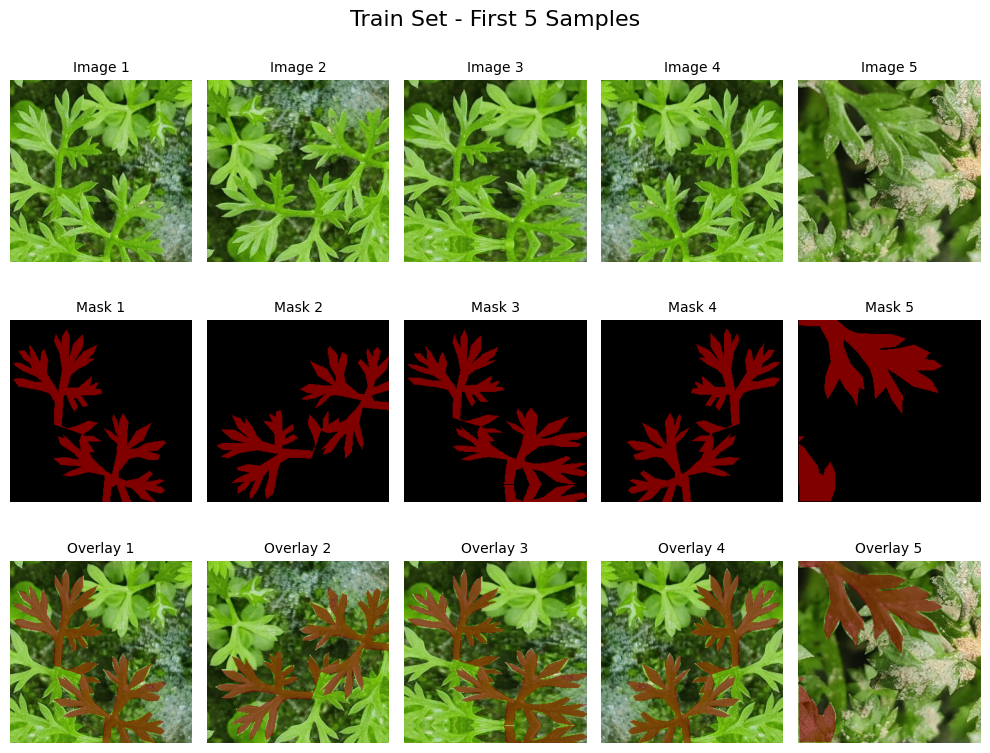

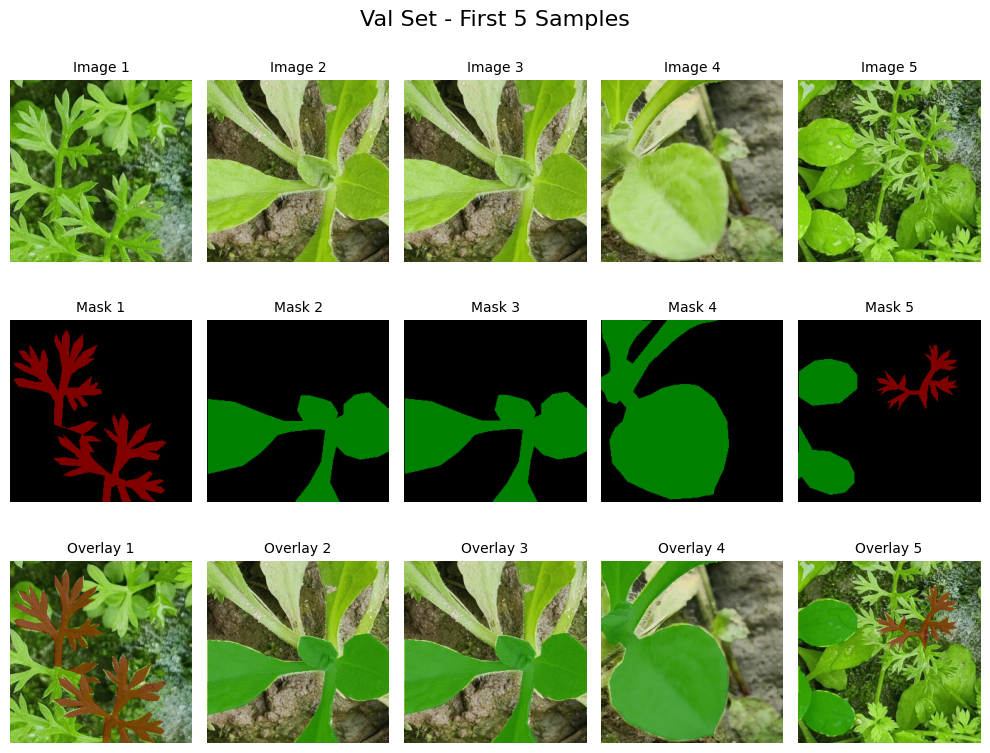

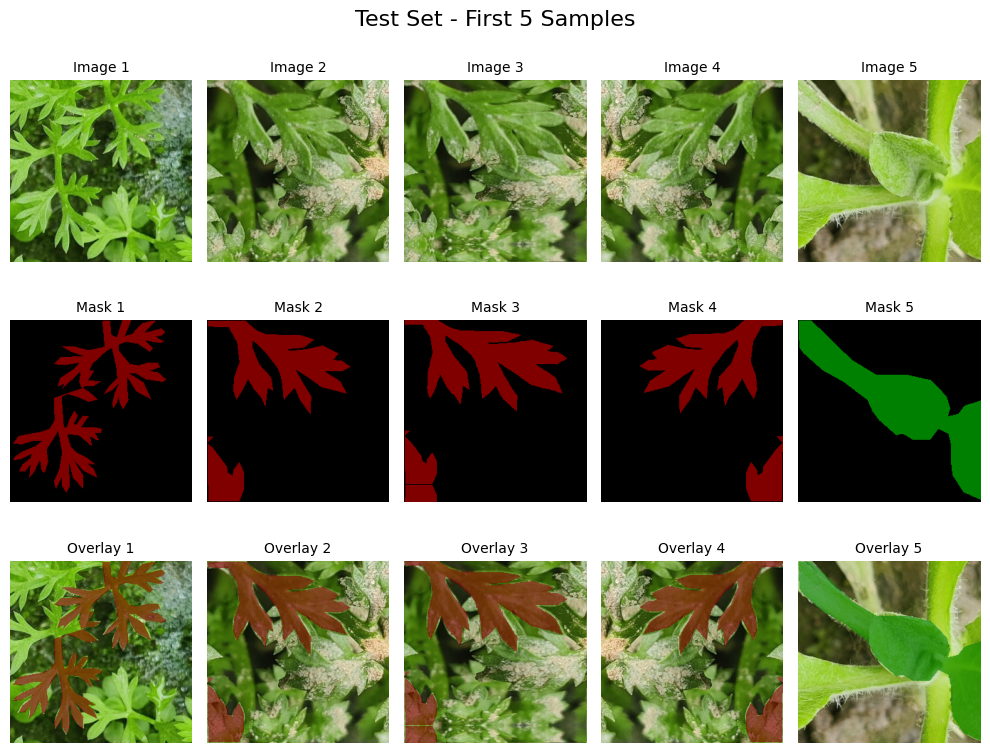

Dataset organized in '.' folder


In [11]:

# Analyze mask colors
mask_folder = os.path.join(output_folder, 'train_masks')
mask_files = [f for f in os.listdir(mask_folder) if f.lower().endswith('.png')]
sample_files = random.sample(mask_files, min(20, len(mask_files)))

all_colors = []
for filename in sample_files:
    mask = cv2.imread(os.path.join(mask_folder, filename))
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
    all_colors.extend([tuple(color) for color in unique_colors])

color_counts = Counter(all_colors)
class_colors = [color for color, _ in color_counts.most_common(10)]

print("Most common mask colors (RGB):")
for color in class_colors[:5]:
    print(f"  {color}")

# Visualize samples
def create_overlay(image, mask, colors, alpha=0.6):
    overlay = image.copy()
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    for color in colors:
        if color == (0, 0, 0):
            continue
        color_mask = np.all(mask_rgb == color, axis=2)
        if np.any(color_mask):
            overlay[color_mask] = (alpha * np.array(color) + (1 - alpha) * overlay[color_mask]).astype(np.uint8)
    return overlay

# Show samples for each split
for split in ['train', 'val', 'test']:
    img_folder = os.path.join(output_folder, f'{split}_images')
    mask_folder = os.path.join(output_folder, f'{split}_masks')

    img_files = sorted([f for f in os.listdir(img_folder) if f.lower().endswith('.png')])[:5]

    if not img_files:
        continue

    fig, axes = plt.subplots(3, len(img_files), figsize=(10, 8))
    fig.suptitle(f'{split.capitalize()} Set - First {len(img_files)} Samples', fontsize=16)

    for i, img_file in enumerate(img_files):
        mask_file = img_file

        img = cv2.imread(os.path.join(img_folder, img_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(mask_folder, mask_file))
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        overlay = create_overlay(img_rgb, mask, class_colors)

        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f'Image {i+1}', fontsize=10)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask_rgb)
        axes[1, i].set_title(f'Mask {i+1}', fontsize=10)
        axes[1, i].axis('off')

        axes[2, i].imshow(overlay)
        axes[2, i].set_title(f'Overlay {i+1}', fontsize=10)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

print(f"Dataset organized in '{output_folder}' folder")

In [3]:
!pip install colorama

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Make sure you have all the necessary imports at the top
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import glob
from pathlib import Path
from tqdm import tqdm
from colorama import Fore, Style

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### Use the [ResUNet++](https://arxiv.org/pdf/1911.07067) model for image segmentation, which is very lightweight in itself.

In [2]:
# https://github.com/DebeshJha/ResUNetPlusPlus-with-CRF-and-TTA/blob/master/resunet%2B%2B_pytorch.py

# Note: This uses 3 channel input

import torch
import torch.nn as nn
import torch.nn.functional as F

class Squeeze_Excitation(nn.Module):
    def __init__(self, channel, r=8):
        super().__init__()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        b, c, _, _ = inputs.shape
        x = self.pool(inputs).view(b, c)
        x = self.net(x).view(b, c, 1, 1)
        x = inputs * x
        return x

class Stem_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)


    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y

class Attention_Block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        out_c = in_c[1]

        self.g_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[0]),
            nn.ReLU(),
            nn.Conv2d(in_c[0], out_c, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2))
        )

        self.x_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(in_c[1], out_c, kernel_size=3, padding=1),
        )

        self.gc_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

    def forward(self, g, x):
        g_pool = self.g_conv(g)
        x_conv = self.x_conv(x)
        gc_sum = g_pool + x_conv
        gc_conv = self.gc_conv(gc_sum)
        y = gc_conv * x
        return y

class Decoder_Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.a1 = Attention_Block(in_c)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.r1 = ResNet_Block(in_c[0]+in_c[1], out_c, stride=1)

    def forward(self, g, x):
        d = self.a1(g, x)
        d = self.up(d)
        d = torch.cat([d, g], axis=1)
        d = self.r1(d)
        return d

class ResUnetPlusPlus(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()

        self.num_classes = n_class

        self.c1 = Stem_Block(input_ch, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)

        self.b1 = ASPP(128, 256)

        self.d1 = Decoder_Block([64, 256], 128)
        self.d2 = Decoder_Block([32, 128], 64)
        self.d3 = Decoder_Block([16, 64], 32)

        self.aspp = ASPP(32, 16)
        self.output = nn.Conv2d(16, n_class, kernel_size=1, padding=0)

    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        b1 = self.b1(c4)

        d1 = self.d1(c3, b1)
        d2 = self.d2(c2, d1)
        d3 = self.d3(c1, d2)

        output = self.aspp(d3)
        output = self.output(output)

        if self.num_classes == 1:
            output = torch.sigmoid(output)
        elif self.num_classes > 1:
            output = F.softmax(output, dim = 1)

        return output

In [3]:
# Use the data generator to load the dataset
class DataGenerator(Dataset):
    def __init__(self, image_list, masks_folder, num_classes=3):
        self.files = image_list
        self.masks_folder = masks_folder
        self.num_classes = num_classes
    
    # NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)

    # GETTING SINGLE PAIR OF DATA
    def __getitem__(self, idx):
        file_name = self.files[idx].split('/')[-1]
        file_name = file_name[:-4]

        mask_name = './{}/'.format(self.masks_folder) + file_name + '.png'

        img = cv2.imread(self.files[idx], cv2.IMREAD_UNCHANGED)
        if len(img.shape) == 2:
            img = cv2.merge((img, img, img))
        
        # Read mask as 3-channel for multi-class
        mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)  # Read as BGR
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)     # Convert to RGB
        
        # Convert RGB mask to class indices (0, 1, 2)
        # Assuming: Black (0,0,0) = background(0), Red-ish = class-1(1), Green-ish = class-2(2)
        mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.long)
        
        # Define color thresholds for each class
        # Background: mostly black/dark
        background_mask = (mask.sum(axis=2) < 50)
        
        # Class 1: red-ish (R > G and R > B)
        class1_mask = (mask[:,:,0] > mask[:,:,1]) & (mask[:,:,0] > mask[:,:,2]) & (mask[:,:,0] > 50)
        
        # Class 2: green-ish (G > R and G > B) 
        class2_mask = (mask[:,:,1] > mask[:,:,0]) & (mask[:,:,1] > mask[:,:,2]) & (mask[:,:,1] > 50)
        
        mask_class[background_mask] = 0
        mask_class[class1_mask] = 1
        mask_class[class2_mask] = 2
        
        # Transpose image
        img_transpose = np.transpose(img, (2, 0, 1))
        
        # Normalize image to [0, 1]
        img_normalized = img_transpose / 255.0

        return torch.FloatTensor(img_normalized), torch.LongTensor(mask_class), str(file_name)


def load_data(image_list, masks_folder, batch_size=2, num_workers=10, shuffle=True, num_classes=3):
    dataset = DataGenerator(image_list, masks_folder=masks_folder, num_classes=num_classes)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader


In [4]:
# Dice coefficient calculation for multi-class with class indices
def dice_coefficient(pred, target, num_classes, smooth=1e-6):
    """
    Calculate dice coefficient for multi-class segmentation
    pred: predicted probabilities [B, C, H, W] (after softmax)
    target: ground truth class indices [B, H, W]
    """
    dice_scores = []
    
    # Convert predictions to class predictions
    pred_classes = torch.argmax(pred, dim=1)  # [B, H, W]
    
    for class_idx in range(num_classes):
        pred_class = (pred_classes == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum(dim=(1, 2))
        union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2))
        
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.mean())
    
    return torch.stack(dice_scores), torch.stack(dice_scores).mean()


# IoU calculation for multi-class with class indices
def iou_coefficient(pred, target, num_classes, smooth=1e-6):
    """
    Calculate IoU for multi-class segmentation
    pred: predicted probabilities [B, C, H, W] (after softmax)
    target: ground truth class indices [B, H, W]
    """
    iou_scores = []
    
    # Convert predictions to class predictions
    pred_classes = torch.argmax(pred, dim=1)  # [B, H, W]
    
    for class_idx in range(num_classes):
        pred_class = (pred_classes == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum(dim=(1, 2))
        union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2)) - intersection
        
        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou.mean())
    
    return torch.stack(iou_scores), torch.stack(iou_scores).mean()


# Categorical Cross Entropy Loss with optional class weights
class CategoryCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CategoryCrossEntropyLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=weight)
    
    def forward(self, pred, target):
        """
        pred: [B, C, H, W] - raw logits from model
        target: [B, H, W] - class indices
        """
        return self.criterion(pred, target)




In [5]:
# Create color map for visualization
def create_color_map():
    """Create color map for 3 classes: background, class-1, class-2"""
    color_map = np.array([
        [0, 0, 0],       # Background - Black
        [255, 0, 0],     # Class 1 - Red
        [0, 255, 0],     # Class 2 - Green
    ], dtype=np.uint8)
    return color_map


def apply_color_map(mask, color_map):
    """Apply color map to single channel mask"""
    h, w = mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        colored_mask[mask == class_idx] = color
    return colored_mask


def create_overlay(image, mask, alpha=0.6):
    """Create overlay of image and colored mask"""
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Image is already RGB
        overlay = cv2.addWeighted(image.astype(np.uint8), 1-alpha, mask.astype(np.uint8), alpha, 0)
    else:
        # Convert grayscale to RGB if needed
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        overlay = cv2.addWeighted(image.astype(np.uint8), 1-alpha, mask.astype(np.uint8), alpha, 0)
    return overlay

In [6]:

# sanity check
def get_image_address(image_data_folder, subfolder_name):
    total_imgs = glob.glob(image_data_folder+subfolder_name+"/*.png")
    error_counter = 0
    TOTAL_COUNT = len(total_imgs)
    image_address_list = []
    for image_name in total_imgs:
        try:
            img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
            x = img.shape
            image_address_list.append(image_name)
        except:
            print("Image not found : ",image_name)
            error_counter+=1
    print("Number of Files not found : ", error_counter)
    print("Total Number of Files found : ", len(image_address_list))
    return image_address_list


In [7]:
# save checkpoint in pytorch
def save_ckp(checkpoint, checkpoint_path, save_after_epochs):
    if checkpoint['epoch'] % save_after_epochs == 0:
        torch.save(checkpoint, checkpoint_path)


# load checkpoint in pytorch
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']


In [8]:

def train_epoch(train_loader, model, optimizer, epoch, hist_folder_name, num_classes=3):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    
    model.train()
    
    # Initialize loss function with class weights (optional - adjust based on your class imbalance)
    class_weights = torch.FloatTensor([0.5, 1.0, 1.0]).to(device)  # Less weight for background
    criterion = CategoryCrossEntropyLoss(weight=class_weights)
    
    for step, (inp__, gt__, file_name) in progress_bar:
        #TRANSFERRING DATA TO DEVICE
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        # clear the gradient
        optimizer.zero_grad()

        #GETTING THE PREDICTED IMAGE (raw logits)
        pred_logits = model.forward(inp__)
        
        # Apply softmax for probability calculation (for metrics only)
        pred_probs = torch.softmax(pred_logits, dim=1)

        #CALCULATING LOSS (using raw logits)
        loss = criterion(pred_logits, gt__)

        #LOSS TAKEN INTO CONSIDERATION
        total_loss += loss.item()

        # Calculate metrics using probabilities
        with torch.no_grad():
            dice_per_class, mean_dice = dice_coefficient(pred_probs, gt__, num_classes)
            iou_per_class, mean_iou = iou_coefficient(pred_probs, gt__, num_classes)
            total_dice += mean_dice.item()
            total_iou += mean_iou.item()

        #BACKPROPAGATING THE LOSS
        loss.backward()
        optimizer.step()

        #DISPLAYING THE LOSS
        progress_bar.set_description("Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    avg_iou = total_iou / len(train_loader)

    with open("{}/train_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))

    print(Fore.GREEN+"Training Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)

    return model, optimizer

In [9]:
def val_epoch(val_loader, model, optimizer, epoch, hist_folder_name, num_classes=3):
    model.eval()
    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    class_weights = torch.FloatTensor([0.5, 1.0, 1.0]).to(device)
    criterion = CategoryCrossEntropyLoss(weight=class_weights)
    
    for step, (inp__, gt__, file_name) in progress_bar:
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        #PREDICTED IMAGE
        pred_logits = model.forward(inp__)
        pred_probs = torch.softmax(pred_logits, dim=1)

        #CALCULATING LOSSES
        loss = criterion(pred_logits, gt__)
        total_loss += loss.item()

        # Calculate metrics
        dice_per_class, mean_dice = dice_coefficient(pred_probs, gt__, num_classes)
        iou_per_class, mean_iou = iou_coefficient(pred_probs, gt__, num_classes)
        total_dice += mean_dice.item()
        total_iou += mean_iou.item()

        progress_bar.set_description("Val Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

    avg_loss = total_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)
    avg_iou = total_iou / len(val_loader)

    with open("{}/val_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))
    
    print(Fore.BLUE+"Validation Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)


In [10]:

def test_epoch(test_loader, model, optimizer, epoch, inf_folder_name, hist_folder_name, num_classes=3):
    model.eval()
    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20
    
    class_weights = torch.FloatTensor([0.5, 1.0, 1.0]).to(device)
    criterion = CategoryCrossEntropyLoss(weight=class_weights)
    
    # Get color map for visualization
    color_map = create_color_map()
    
    for step, (inp__, gt__, file_name) in progress_bar:
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        #PREDICTED IMAGE
        pred_logits = model.forward(inp__)
        pred_probs = torch.softmax(pred_logits, dim=1)

        #CALCULATING LOSSES
        loss = criterion(pred_logits, gt__)
        total_loss += loss.item()
        
        # Calculate metrics
        dice_per_class, mean_dice = dice_coefficient(pred_probs, gt__, num_classes)
        iou_per_class, mean_iou = iou_coefficient(pred_probs, gt__, num_classes)
        total_dice += mean_dice.item()
        total_iou += mean_iou.item()

        progress_bar.set_description("Test Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

        #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
        if(step < no_img_to_write):
            
            pred_classes = torch.argmax(pred_probs, dim=1)  # Get class predictions
            p_img = pred_classes.cpu().numpy()  # [B, H, W]
            gt_img = gt__.cpu().numpy()  # [B, H, W]  
            inp_img = inp__.cpu().numpy()  # [B, C, H, W]
            
            #FOLDER PATH TO WRITE THE INFERENCES
            inference_folder = "{}".format(inf_folder_name)
            if not os.path.isdir(inference_folder):
                os.mkdir(inference_folder)
            
            print("\n Saving inferences at epoch === ",epoch)

            # Save inference images for multi-class with overlays
            for batch_idx, (p_image_loop, gt_img_loop, inp_img_loop) in enumerate(zip(p_img, gt_img, inp_img)):
                
                # Prepare input image for overlay
                inp_img_display = np.transpose(inp_img_loop, (1, 2, 0))  # [H, W, C]
                inp_img_display = (inp_img_display * 255.0).astype(np.uint8)
                
                # 1. Save raw input image
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_input.png"), 
                           cv2.cvtColor(inp_img_display, cv2.COLOR_RGB2BGR))
                
                # 2. Create and save colored prediction mask
                pred_colored = apply_color_map(p_image_loop, color_map)
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_pred_mask.png"), 
                           cv2.cvtColor(pred_colored, cv2.COLOR_RGB2BGR))
                
                # 3. Create and save colored ground truth mask  
                gt_colored = apply_color_map(gt_img_loop, color_map)
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_gt_mask.png"), 
                           cv2.cvtColor(gt_colored, cv2.COLOR_RGB2BGR))
                
                # 4. Create and save prediction overlay
                pred_overlay = create_overlay(inp_img_display, pred_colored, alpha=0.4)
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_pred_overlay.png"), 
                           cv2.cvtColor(pred_overlay, cv2.COLOR_RGB2BGR))
                
                # 5. Create and save ground truth overlay
                gt_overlay = create_overlay(inp_img_display, gt_colored, alpha=0.4)
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_gt_overlay.png"), 
                           cv2.cvtColor(gt_overlay, cv2.COLOR_RGB2BGR))
                
                # 6. Create side-by-side comparison
                comparison = np.hstack([
                    inp_img_display,
                    gt_colored,
                    pred_colored,
                    gt_overlay,
                    pred_overlay
                ])
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_comparison.png"), 
                           cv2.cvtColor(comparison, cv2.COLOR_RGB2BGR))

    avg_loss = total_loss / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    avg_iou = total_iou / len(test_loader)

    with open("{}/test_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))
    
    print(Fore.RED+"Test Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)
    print("---------------------------------------------------------------------------------------------------------------")


In [11]:

def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume, model_name, inf_folder_name, hist_folder_name, save_after_epochs, num_classes=3):

    Path(inf_folder_name).mkdir(parents=True, exist_ok=True)
    Path(hist_folder_name).mkdir(parents=True, exist_ok=True)

    epoch = 0

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint/{}_{}.pt".format(model_name,epoch)

    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        checkpoint_path = "checkpoint/{}_{}.pt".format(model_name,epoch)
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch, hist_folder_name, num_classes)
        
        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}
        
        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path, save_after_epochs)
        print(Fore.BLACK+"Checkpoint Saved"+Style.RESET_ALL)

        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch, hist_folder_name, num_classes)

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch, inf_folder_name, hist_folder_name, num_classes)


In [12]:

def main():
    # Set your parameters directly here for Jupyter notebook
    class Args:
        def __init__(self):
            # Training parameters
            self.lr = "0.001"
            self.batch_size = "64"
            self.num_epochs = "10"
            self.num_classes = 3
            
            # Dataset folders
            self.train_images = "train_images"
            self.val_images = "val_images"
            self.test_images = "test_images"
            
            self.train_masks = "train_masks"
            self.val_masks = "val_masks"
            self.test_masks = "test_masks"
            
            # Output folders
            self.history_folder_name = "history"
            self.inference_folder_name = "inference"
            self.chkpt_name = "multiclass_model"
            self.save_after_epoch = "10"
    
    args = Args()

    train_image_address_list = get_image_address("./", args.train_images)
    print("Total Number of Training Images : ", len(train_image_address_list))

    val_image_address_list = get_image_address("./", args.val_images)
    test_image_address_list = get_image_address("./", args.test_images)

    train_masks = args.train_masks
    val_masks = args.val_masks
    test_masks = args.test_masks
    save_after_epochs = int(args.save_after_epoch)
    num_classes = args.num_classes

    # CREATING THE TRAIN LOADER
    train_loader = load_data(
        train_image_address_list, masks_folder=train_masks, batch_size=int(args.batch_size), 
        num_workers=8, shuffle=True, num_classes=num_classes)

    val_loader = load_data(
        val_image_address_list, masks_folder=val_masks, batch_size=int(args.batch_size), 
        num_workers=8, shuffle=True, num_classes=num_classes)
    
    # CREATING THE TEST LOADER
    test_loader = load_data(
        test_image_address_list, masks_folder=test_masks, batch_size=1, 
        num_workers=8, shuffle=False, num_classes=num_classes)

    # CALLING THE MODEL - Make sure your model outputs num_classes channels
    model = ResUnetPlusPlus(input_ch=3, n_class=num_classes)  # Change this to match your model
    # model = nn.DataParallel(model)
    model = model.to(device)

    # DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=float(args.lr), weight_decay=5e-4)
    
    n_epoch = int(args.num_epochs)

    # INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    model_name = args.chkpt_name
    inf_folder_name = args.inference_folder_name
    hist_folder_name = args.history_folder_name
    
    train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume, 
                   model_name, inf_folder_name, hist_folder_name, save_after_epochs, num_classes)

if __name__ == "__main__":
    main()

Number of Files not found :  0
Total Number of Files found :  4723
Total Number of Training Images :  4723
Number of Files not found :  0
Total Number of Files found :  787
Number of Files not found :  0
Total Number of Files found :  2362


---------------------------------------------------------------------------------------------------------------



Epoch: 1 - Loss: 0.8153 - Dice: 0.5018 - IoU: 0.4482: : 74it [00:42,  1.74it/s]

Training Epoch: 1 | Loss: 0.8739 | Dice: 0.4352 | IoU: 0.3707
Checkpoint Saved



Val Epoch: 1 - Loss: 0.8360 - Dice: 0.5049 - IoU: 0.4416: : 13it [00:02,  4.94it/s]

Validation Epoch: 1 | Loss: 0.8366 | Dice: 0.4859 | IoU: 0.4246


---------------------------------------------------------------------------------------------------------------




Epoch: 2 - Loss: 0.8377 - Dice: 0.4335 - IoU: 0.3651: : 74it [00:42,  1.75it/s]

Training Epoch: 2 | Loss: 0.8127 | Dice: 0.5035 | IoU: 0.4440
Checkpoint Saved



Val Epoch: 2 - Loss: 0.8142 - Dice: 0.5202 - IoU: 0.4648: : 13it [00:02,  4.83it/s]

Validation Epoch: 2 | Loss: 0.8171 | Dice: 0.5018 | IoU: 0.4379


---------------------------------------------------------------------------------------------------------------




Epoch: 3 - Loss: 0.7903 - Dice: 0.5031 - IoU: 0.4488: : 74it [00:42,  1.73it/s]

Training Epoch: 3 | Loss: 0.8027 | Dice: 0.5137 | IoU: 0.4538
Checkpoint Saved



Val Epoch: 3 - Loss: 0.8124 - Dice: 0.5102 - IoU: 0.4408: : 13it [00:02,  4.88it/s]

Validation Epoch: 3 | Loss: 0.8092 | Dice: 0.5061 | IoU: 0.4420


---------------------------------------------------------------------------------------------------------------




Epoch: 4 - Loss: 0.8338 - Dice: 0.4666 - IoU: 0.3992: : 74it [00:42,  1.73it/s]

Training Epoch: 4 | Loss: 0.7948 | Dice: 0.5253 | IoU: 0.4641
Checkpoint Saved



Val Epoch: 4 - Loss: 0.8458 - Dice: 0.4883 - IoU: 0.4501: : 13it [00:02,  5.03it/s]

Validation Epoch: 4 | Loss: 0.8220 | Dice: 0.5340 | IoU: 0.4831


---------------------------------------------------------------------------------------------------------------




Epoch: 5 - Loss: 0.8129 - Dice: 0.5100 - IoU: 0.4455: : 74it [00:42,  1.73it/s]

Training Epoch: 5 | Loss: 0.7919 | Dice: 0.5209 | IoU: 0.4568
Checkpoint Saved



Val Epoch: 5 - Loss: 0.7915 - Dice: 0.6291 - IoU: 0.5695: : 13it [00:02,  4.86it/s]

Validation Epoch: 5 | Loss: 0.8013 | Dice: 0.5696 | IoU: 0.5151


---------------------------------------------------------------------------------------------------------------




Epoch: 6 - Loss: 0.7879 - Dice: 0.5618 - IoU: 0.4951: : 74it [00:42,  1.74it/s]

Training Epoch: 6 | Loss: 0.7834 | Dice: 0.5277 | IoU: 0.4620
Checkpoint Saved



Val Epoch: 6 - Loss: 0.8043 - Dice: 0.5108 - IoU: 0.4371: : 13it [00:02,  4.88it/s]

Validation Epoch: 6 | Loss: 0.7848 | Dice: 0.5405 | IoU: 0.4725


---------------------------------------------------------------------------------------------------------------




Epoch: 7 - Loss: 0.7468 - Dice: 0.5638 - IoU: 0.5014: : 74it [00:42,  1.74it/s]

Training Epoch: 7 | Loss: 0.7792 | Dice: 0.5394 | IoU: 0.4746
Checkpoint Saved



Val Epoch: 7 - Loss: 0.8025 - Dice: 0.5735 - IoU: 0.5004: : 13it [00:02,  4.87it/s]

Validation Epoch: 7 | Loss: 0.7888 | Dice: 0.5286 | IoU: 0.4663


---------------------------------------------------------------------------------------------------------------




Epoch: 8 - Loss: 0.7663 - Dice: 0.5054 - IoU: 0.4417: : 74it [00:42,  1.74it/s]

Training Epoch: 8 | Loss: 0.7736 | Dice: 0.5401 | IoU: 0.4728
Checkpoint Saved



Val Epoch: 8 - Loss: 0.8312 - Dice: 0.4663 - IoU: 0.4035: : 13it [00:02,  4.87it/s]

Validation Epoch: 8 | Loss: 0.7827 | Dice: 0.5251 | IoU: 0.4582


---------------------------------------------------------------------------------------------------------------




Epoch: 9 - Loss: 0.7858 - Dice: 0.5031 - IoU: 0.4340: : 74it [00:42,  1.75it/s]

Training Epoch: 9 | Loss: 0.7729 | Dice: 0.5432 | IoU: 0.4767
Checkpoint Saved



Val Epoch: 9 - Loss: 0.7611 - Dice: 0.4848 - IoU: 0.4157: : 13it [00:02,  4.84it/s]

Validation Epoch: 9 | Loss: 0.7826 | Dice: 0.5035 | IoU: 0.4307


---------------------------------------------------------------------------------------------------------------




Epoch: 10 - Loss: 0.7552 - Dice: 0.5788 - IoU: 0.5117: : 74it [00:42,  1.74it/s]

Training Epoch: 10 | Loss: 0.7721 | Dice: 0.5399 | IoU: 0.4721
Checkpoint Saved



Val Epoch: 10 - Loss: 0.7607 - Dice: 0.5666 - IoU: 0.4938: : 13it [00:02,  4.82it/s]

Validation Epoch: 10 | Loss: 0.7750 | Dice: 0.5476 | IoU: 0.4867


---------------------------------------------------------------------------------------------------------------




Epoch: 11 - Loss: 0.7709 - Dice: 0.5754 - IoU: 0.5107: : 74it [00:42,  1.74it/s]

Training Epoch: 11 | Loss: 0.7694 | Dice: 0.5475 | IoU: 0.4804
Checkpoint Saved



Val Epoch: 11 - Loss: 0.7803 - Dice: 0.6033 - IoU: 0.5409: : 13it [00:02,  4.87it/s]

Validation Epoch: 11 | Loss: 0.8006 | Dice: 0.5580 | IoU: 0.5027
************************ Final Test Epoch *****************************



Test Epoch: 11 - Loss: 0.6798 - Dice: 0.8221 - IoU: 0.7512: : 0it [00:00, ?it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 0.6951 - Dice: 0.4238 - IoU: 0.3663: : 6it [00:00, 29.77it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 0.6363 - Dice: 0.9093 - IoU: 0.8512: : 6it [00:00, 29.77it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 1.0230 - Dice: 0.6110 - IoU: 0.5107: : 14it [00:00, 35.61it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 0.7526 - Dice: 0.8537 - IoU: 0.7672: : 18it [00:00, 36.76it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 0.7658 - Dice: 0.4087 - IoU: 0.3370: : 29it [00:00, 60.72it/s]


 Saving inferences at epoch ===  11

 Saving inferences at epoch ===  11


Test Epoch: 11 - Loss: 0.9409 - Dice: 0.6898 - IoU: 0.5772: : 2362it [00:15, 147.75it/s]


Test Epoch: 11 | Loss: 0.7941 | Dice: 0.5600 | IoU: 0.5056
---------------------------------------------------------------------------------------------------------------
